# Álgebra linear para ciência de dados

## Tarefa: aula 8

### Video denoising usando Reduced-Rank Regression (RRR)

Usando as notas de aula como base, visamos construir um problema

$\min_{\Theta \ \in \ \mathbb{R}^{p \times k}} \{ ||Y - X \Theta||^2_F + \lambda ||\Theta||_* \}$.

A [formulação](https://andrewcharlesjones.github.io/journal/reduced-rank-regression.html) do RRR propõe que $X$ e $Y$ sejam séries de amostras de um mesmo problema, porém de features diferentes.

No caso do video-denoising, nossa principal dificuldade está na construção de $X$. $Y$ já está bem definida, sendo o vídeo em si, com cada frame sendo uma coluna.

Vamos então atacar o problem da seguinte forma: assumindo que $Y$ seja o vídeo ruidoso, nosso objetivo
é obter uma matriz $\Theta$ para qual $X\Theta$ seja o vídeo sem ruído ou, melhor ainda

$Y = X\Theta + E$,

onde $E$ representa o ruído.

Ideia: obter X com PCA

In [1]:
import numpy as np
import cv2
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

In [2]:
vid = cv2.VideoCapture('video_noisy.mp4')
frames = []
while vid.isOpened():
    ret, frame = vid.read()
    if ret:
        # Convert to grayscale and flatten
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(frame_gray.flatten())
    else:
        break
vid.release()
frames = np.array(frames).T
Y = frames

In [3]:
frames.shape

(102240, 120)

#### Abordagem 1: X por PCA

In [4]:
# Number of principal components to retain
n_components = 10

# Apply PCA for dimensionality reduction
pca = PCA(n_components=n_components)
X = pca.fit_transform(frames)

In [5]:
X.shape

(102240, 10)

In [6]:
ridge_regressor = Ridge(alpha=0.1)
ridge_regressor.fit(X, Y)

Ridge(alpha=0.1)

In [7]:
B = ridge_regressor.coef_

In [8]:
B.shape

(120, 10)

In [9]:
Y_reconstructed = X @ B.T
Y_reconstructed.shape

(102240, 120)

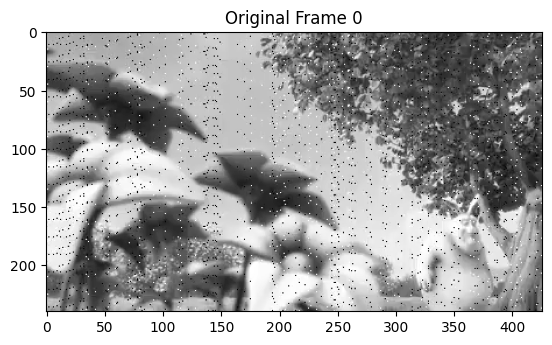

In [10]:
# plot frame 0
plt.figure()
plt.imshow(frames[:, 0].reshape(240, 426), cmap='gray')
plt.title('Original Frame 0')
plt.show()

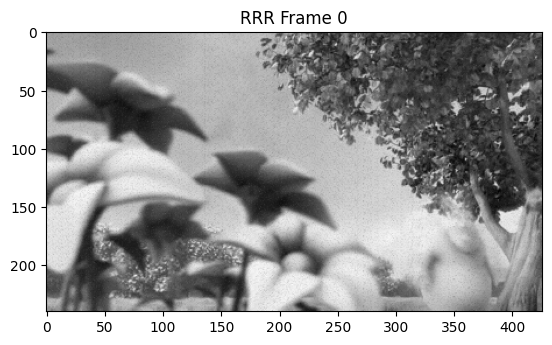

In [11]:
# plot frame 0
plt.figure()
plt.imshow(Y_reconstructed[:, 8].reshape(240, 426), cmap='gray')
plt.title('RRR Frame 0')
plt.show()

In [ ]:
Y_out = Y_reconstructed.T.reshape(-1, 240, 426)
frames_normalized = []
for i, frame in enumerate(Y_out):
    frame_normalized = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    frames_normalized.append(frame_normalized)
# write video
out = cv2.VideoWriter('out/video_reconstructed.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 30, (426, 240))
for frame in frames_normalized:
    out.write(cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR))
out.release()

In [13]:
# svd em Y_reconstructed
U, S, Vt = np.linalg.svd(Y_reconstructed, full_matrices=False)

In [17]:
rank = 10
f = Vt[:rank, :].T @ (Vt[:rank, :] @ B)
f.shape

(120, 10)

#### Abordagem 2: X como 20 primeiros frames limpos

In [129]:
vid2 = cv2.VideoCapture('video.mp4')
frames2 = []
while vid2.isOpened():
    ret, frame = vid2.read()
    if ret:
        # Convert to grayscale and flatten
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames2.append(frame_gray.flatten())
    else:
        break
vid2.release()
frames2 = np.array(frames2)
X = frames2.T
X = X[:, :20]
X.shape

(102240, 20)

In [133]:
# only last 100 cols
Y2 = Y[:, 20:]
Y2.shape

(102240, 100)

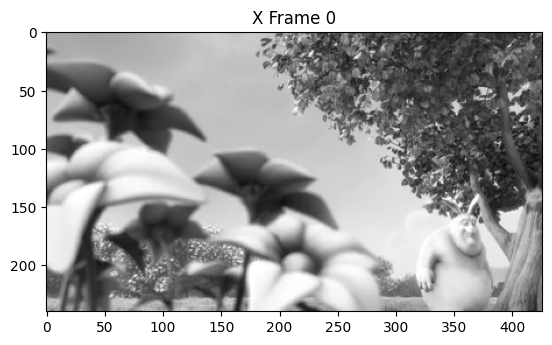

In [134]:
# plot frame 0
plt.figure()
plt.imshow(X[:, 0].reshape(240, 426), cmap='gray')
plt.title('X Frame 0')
plt.show()

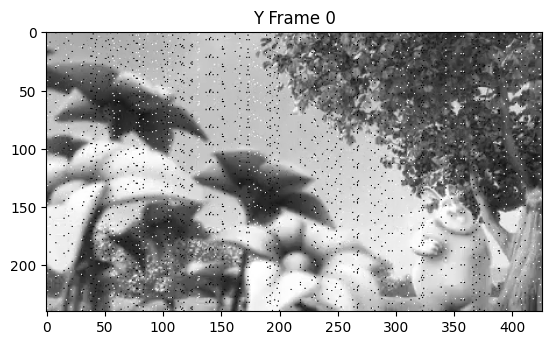

In [136]:
# plot frame 0
plt.figure()
plt.imshow(Y2[:, 0].reshape(240, 426), cmap='gray')
plt.title('Y Frame 0')
plt.show()

In [137]:
ridge_regressor = Ridge(alpha=0.1)
ridge_regressor.fit(X, Y2)

Ridge(alpha=0.1)

In [138]:
B = ridge_regressor.coef_
B.shape

(100, 20)

In [139]:
Y2_reconstructed = X @ B.T

In [140]:
Y2_reconstructed.shape

(102240, 100)

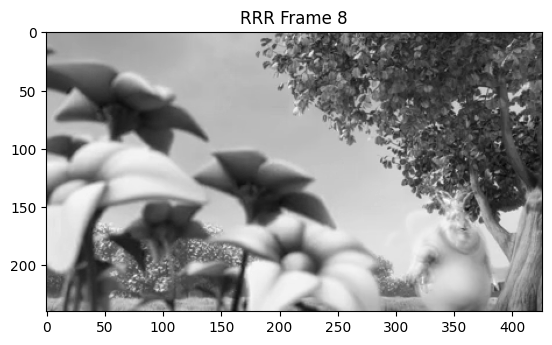

In [141]:
# plot frame 0
plt.figure()
plt.imshow(Y2_reconstructed[:, 8].reshape(240, 426), cmap='gray')
plt.title('RRR Frame 8')
plt.show()

In [142]:
Y_out = Y2_reconstructed.T.reshape(-1, 240, 426)
frames_normalized = []
for i, frame in enumerate(Y_out):
    frame_normalized = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    frames_normalized.append(frame_normalized)
# write video
out = cv2.VideoWriter('video_reconstructed_2.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 30, (426, 240))
for frame in frames_normalized:
    out.write(cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR))
out.release()

Notas:

Não entendi a relação do REDUCED-RANK com o denoising. Nesse caso com o PCA, sim. Mas no caso "normal", não seria apenas uma regrssão?

Porque, até onde eu vi, o SVD é realizado APÓS a regressão.